<a href="https://colab.research.google.com/github/Jakobs-Ben/Code_for_PXT991/blob/main/Transfer_Matrix_Method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Imports

In [ ]:
import numpy as np
import pandas as pd
from itertools import product

import matplotlib.pyplot as plt
import seaborn as sns

###Calculation of initial parameters

In [ ]:
## starting parameters
# the first and last layers are air (non-lossy and set to 0 thickness) 
'''lossy medium : a medium in which a significant amount of the energy of a propagating 
electromagnetic wave is absorbed per unit distance traveled by the wave'''
# assuming we are interested in optical responses of the structure in the middle 
# thickness is given in nm  
thickness     = np.array([0, 1500, 500, 0])
ep            = np.array([1, 2, 12, 1])

# consistent units e.g. if wavelength is in nm, film thickness should also be in nm
wavelength    = 500
n             = np.sqrt(ep)
k             = 2*np.pi*n/wavelength

# define angle of incidence
theta_inc     = 0
theta_inc_rad = np.deg2rad(theta_inc)

# wavenumber in incidence material
k_inc         = k[0]

# tangent component of wavenumber
k_tan         = k_inc*np.sin(theta_inc_rad)

# angle of incidence in all layers
theta         = 0               #np.arcsin(k_tan/k)

# propagating component of wavenumber in all layers
k_prop        = np.sqrt(np.square(k) - np.square(k_tan))
# or -- k_prop        = k*np.cos(theta)

# phase gain in all layers
delta         = k*np.cos(theta)*thickness

###Function to calculate the transfer matrix at each layer

In [ ]:
def transfer_matrix_layer(delta_now, n1, n2, theta1, theta2):
    ''' 
    Calculate transfer-matrix of each layer.
    '''

    ## TE component
    # propagation matrix
    prp_te = np.array( [[np.exp(-1j*delta_now), 0], [0, np.exp(1j*delta_now)]] )
    
    # reflection matrix
    r_te   = (n1*np.cos(theta1) - n2*np.cos(theta2)) / (n1*np.cos(theta1) + n2*np.cos(theta2))
    t_te   = 2*n1*np.cos(theta1) / (n1*np.cos(theta1) + n2*np.cos(theta2))
    rlc_te = 1 / t_te * np.array( [[1, r_te], [r_te, 1]] )
    
    # combined matrix on that layer
    m_te   = np.matmul(prp_te, rlc_te)
    
    ## TM component
    # propagation matrix -- same as TE
    prp_tm = np.array( [[np.exp(-1j*delta_now), 0], [0, np.exp(1j*delta_now)]] )
    
    # reflection matrix
    r_tm   = (n2*np.cos(theta1) - n1*np.cos(theta2)) / (n2*np.cos(theta1) + n1*np.cos(theta2))
    t_tm   = 2*n1*np.cos(theta1)/(n2*np.cos(theta1) + n1*np.cos(theta2))
    rlc_tm = 1 / t_tm * np.array( [[1, r_tm], [r_tm, 1]])
    
    # combined matrix on that layer
    m_tm   = np.matmul(prp_tm, rlc_tm)
    
    return m_te, m_tm

###Function to calculate the combined transfer matrix for entire dielectric structure

In [ ]:
def transfer_matrix(delta, n, theta):
    ''' 
    Calculate the combined transfer-matrix of wave propagation.
    '''
    # starting matrices start as two identity matricies i.e. [[1,0],[0,1]]
    m_te_all = np.identity(2)
    m_tm_all = np.identity(2)

    # combine transfer matrix of all layers
    for delta_now, n1, n2, theta1, theta2 in zip(delta[:-1], n[:-1], n[1:], theta[:-1], theta[1:]):
        
        # transfer matrix of each layer
        m_te, m_tm = transfer_matrix_layer(delta_now, n1, n2, theta1, theta2)
        
        # multiply to the previous matrix
        m_te_all   = np.matmul(m_te_all, m_te)
        m_tm_all   = np.matmul(m_tm_all, m_tm)
        
    return m_te_all, m_tm_all

###Function to determine the reflectance and transmittance 

In [ ]:
def reflectance_transmitance(delta, n, theta):
    ''' 
    Get optical reflactance and transmittance (TE and TM).
    Valid when first and last layers are non-lossy materials.
    '''
    # get m_te_all and m_tm_all
    m_te_all, m_tm_all = transfer_matrix(delta, n, theta)

    # TE reflection/transmission coefficients
    reflect_te = m_te_all[1,0] / m_te_all[0,0]
    transmt_te = 1 / m_te_all[0,0]
    # TE reflectance and transmittance
    r_power_te = np.abs(reflect_te)**2
    t_power_te = np.abs(transmt_te)**2 * np.real( n[-1]*np.cos(theta[-1]) ) / np.real( n[0]*np.cos(theta[0]) )
    
    # TM reflection/transmission coefficients
    reflect_tm = m_tm_all[1,0] / m_tm_all[0,0]
    transmt_tm = 1 / m_tm_all[0,0]
    # TM reflectance and transmittance
    r_power_tm = np.abs(reflect_tm)**2
    t_power_tm = np.abs(transmt_tm)**2 * np.real( n[-1]*np.cos(theta[-1]) ) / np.real( n[0]*np.cos(theta[0]) )
    
    return r_power_te, t_power_te, r_power_tm, t_power_tm

###Retrieve parameters that have varied during propagation

In [ ]:
def get_params(thickness, n, wavelength, theta_inc):
    '''
    Get varying parameters due to changing wavelength and theta_inc.
    '''
    # calculate wavenumber in all layers
    k             = 2*np.pi*n/wavelength

    # wavenumber in incidence material
    k_inc         = k[0]

    # tangent component of wavenumber
    theta_inc_rad = np.deg2rad(theta_inc)
    k_tan         = k_inc*np.sin(theta_inc_rad)

    # angle of incidence in all layers
    theta         = np.arcsin(k_tan/k)

    # propagating component of wavenumber in all layers
    k_prop        = np.sqrt(np.square(k) - np.square(k_tan))
    # or -- k_prop        = k*np.cos(theta)

    # phase gain in all layers
    delta         = k*np.cos(theta)*thickness
    
    return delta, theta

###Retrieve optical reflectance, transmittance and total of both parameters

In [ ]:
def get_reflectance_transmittance(thickness, n, wavelength):
    '''
    Get optical reflactance and transmittance (TE, TM, and total).
    '''
    delta, theta                                   = get_params(thickness, n, wavelength, theta_inc)
    r_power_te, t_power_te, r_power_tm, t_power_tm = reflectance_transmitance(delta, n, theta)
    
    return r_power_te, t_power_te, r_power_tm, t_power_tm, (r_power_te + r_power_tm)/2, (t_power_te + t_power_tm)/2

###Plotting data

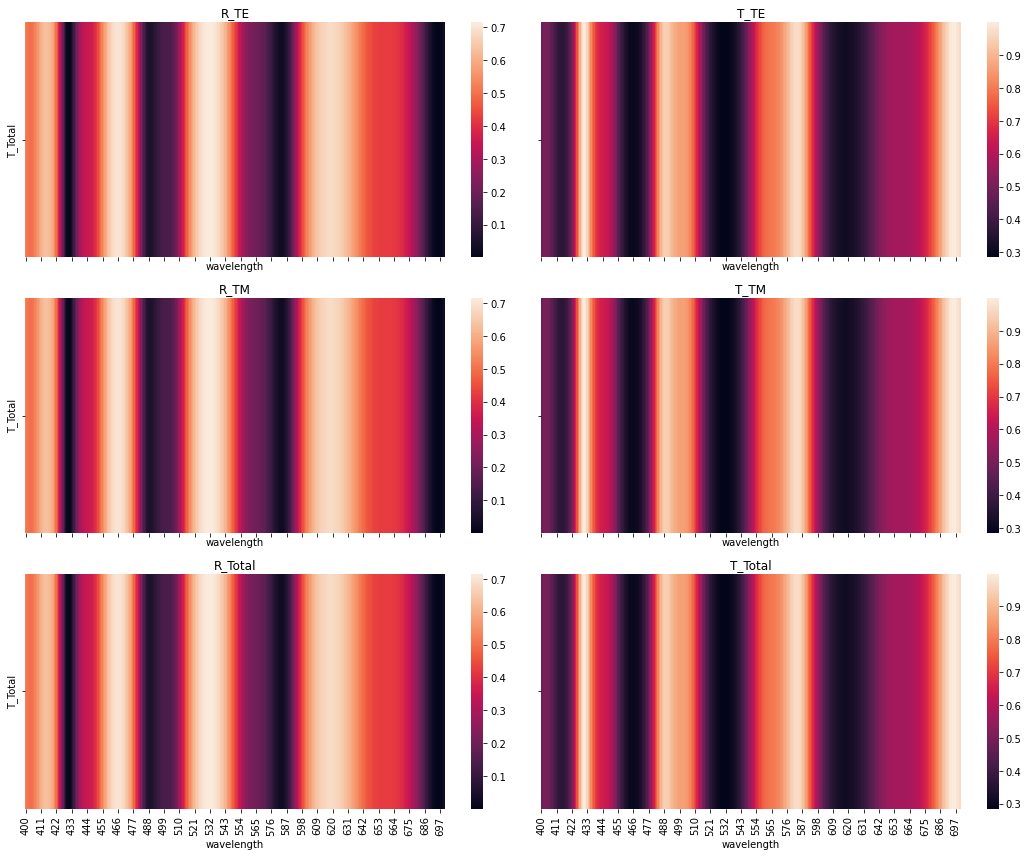

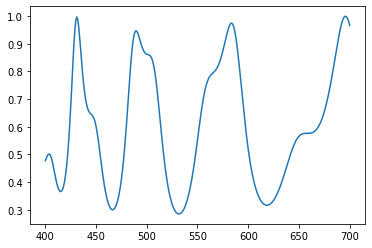

In [ ]:
wavelength_range = range(400, 701, 1)
#theta_inc_range  = range(0, 90, 1)
excitation_df = pd.DataFrame(list(product(wavelength_range)), 
                             columns=['wavelength']
                            )
response_df = pd.concat([excitation_df, 
                         pd.DataFrame(excitation_df.apply(lambda x: 
                                                          get_reflectance_transmittance(thickness, n, x.wavelength)
                                                          , axis=1
                                                         ).tolist(),
                                      columns = ['R_TE', 'T_TE', 'R_TM', 'T_TM', 'R_Total', 'T_Total']
                                     )
                        ],
                        axis=1
                       )
fig, axes = plt.subplots(3, 2, figsize=(15, 12), sharex=True, sharey=True)

for value, ax in zip(['R_TE', 'T_TE', 'R_TM', 'T_TM', 'R_Total', 'T_Total'], axes.flatten()):
    sns.heatmap(pd.pivot_table(response_df, 
                               values=value,  
                               columns='wavelength'
                              ), 
                annot=False, ax=ax
               )
    ax.set_title(value)
    ax.invert_yaxis()

fig.tight_layout()
plt.show()

reflectance = []
for i in range(len(wavelength_range)):
  reflectance.append(get_reflectance_transmittance(thickness, n, wavelength_range[i])[5])

plt.plot(wavelength_range, reflectance)
plt.show()